<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/05-dl-autonomous-vehicle/dl_autonomous_vehicle_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle vs. Animal Classification — Custom CNN

> 👨‍💻 Developed as part of the AI Engineering Master – Week 5  

### 📌 Project Overview  

This project develops and evaluates **Convolutional Neural Networks (CNNs)** to classify **vehicles vs. animals** using the **CIFAR-10 dataset**.  
The task supports applications in **autonomous driving** and **urban traffic monitoring**, where distinguishing vehicles from animals is crucial for safety.  

### 📌 Workflow Steps  

1. **Data Preparation**  
   - Remapping CIFAR-10 classes into a **binary problem** (vehicle vs. animal).  
   - Train/validation split with **data augmentation** for generalization.  

2. **Model Design**  
   - Custom **CNN architectures** with convolution, pooling, dropout, and dense layers.  
   - Comparison of optimizers: **Adam** and **RMSprop with CosineDecay**.  

3. **Training & Evaluation**  
   - Metrics: **Accuracy, Precision, Recall, F1-score**.  
   - Visualization of **learning curves** and **confusion matrices**.  

4. **Comparative Analysis**  
   - **Run A (Baseline)**: Best accuracy (96.2%), balanced precision/recall.  
   - **Run B (Stable)**: Similar accuracy with smoother training dynamics.  
   - **Run C (Light)**: Slightly lower accuracy but higher efficiency for edge deployment.  




In [ ]:
# Disable warnings and logs for clean output
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Load and explore dataset

In [ ]:
# Loading CIFAR-10 dataset and verify shapes
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
class_names = ['vehicle', 'non-vehicle']

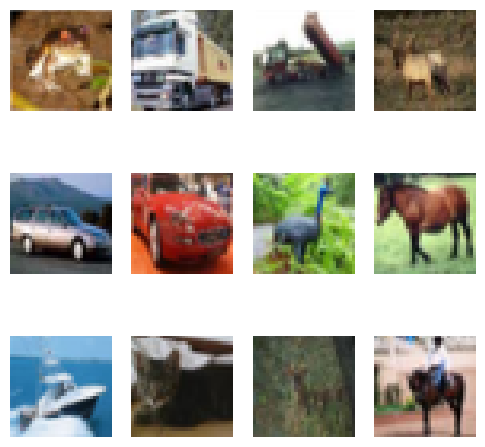

In [ ]:
# Display sample training images to gain initial insights
num_rows, num_cols = 3, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
axes = axes.flatten()
for i in range(num_rows * num_cols):
    axes[i].imshow(x_train[i])
    axes[i].axis('off')
plt.show()

# Dataset preprocessing

In [ ]:
# Preprocess labels for binary classification
# Flatten labels from 2D array (n,1) to 1D (n,)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Map into binary classification: vehicles (0,1,8,9) vs non-vehicles (others)
vehicles = [0, 1, 8, 9]
y_train_bin = np.array([0 if y in vehicles else 1 for y in y_train])
y_test_bin  = np.array([0 if y in vehicles else 1 for y in y_test])

print('True lables:', y_train[:50])
print('Bin lables: ', y_train_bin[:50])

True lables: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3
 7 3 3 5 2 2 7 1 1 1 2 2 0]
Bin lables:  [1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1
 1 1 1 1 1 1 1 0 0 0 1 1 0]


In [ ]:
# Train/validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_bin, test_size=0.3, random_state=42
)

# Model architecture

In [ ]:
# Define CNN architecture
def cnn_model():
    model = Sequential()

    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(Conv2D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Data generators

In [ ]:
# Prepare data generators for augmentation and normalization
datagen_cnn_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.05
)

datagen_cnn_val = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create augmented training and normalized validation generators
train_cnn_gen = datagen_cnn_train.flow(X_train_split, y_train_split, batch_size=256, shuffle=True)
val_cnn_gen   = datagen_cnn_val.flow(X_val_split, y_val_split, batch_size=256, shuffle=False)

# Normalize test data (without augmentation) for evaluation
x_test_norm_cnn = x_test.astype("float32")/255.0

# CNN optimizer

### Alternative optimizer experiment (commented out)
During the experiments, I also tested **RMSprop with Cosine Decay learning rate schedule**.  
This code is left commented for documentation purposes only, since the final chosen configuration used **Adam**.


In [ ]:
# --- Experimental setup (not used in the final run) ---
# decay_steps_cnn = len(train_cnn_gen) * 50  # total steps for ~50 epochs
# lr_schedule_cnn = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=decay_steps_cnn,
#     alpha=1e-5
# )
# optimizer_cnn = RMSprop(learning_rate=lr_schedule_cnn)
# metrics = ['accuracy', Precision(), Recall()]

In [ ]:
# Define optimizer and metrics
optimizer_cnn = Adam(learning_rate=1e-3)
metrics = ['accuracy', Precision(), Recall()]

# Training

In [ ]:
# Train the CNN model with early stopping to prevent overfitting
cnn = cnn_model()
# Compile the CNN model
cnn.compile(optimizer=optimizer_cnn,
            loss='binary_crossentropy',
            metrics=metrics)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
)

In [ ]:
history_cnn = cnn.fit(
    train_cnn_gen,
    epochs=50,
    validation_data=val_cnn_gen,
    callbacks=[early_stop]
)

# Evaluate final model performance on the test set
test_metrics_cnn = cnn.evaluate(x_test_norm_cnn, y_test_bin)
print("\nTest Metrics:", dict(zip(cnn.metrics_names, [f"{v:.2f}" for v in test_metrics_cnn])))

# Training curves

In [ ]:
# Plot training curves to analyze training progress and convergence
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train loss')
plt.plot(history_cnn.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

# Classification report

In [ ]:
# Generate classification report with precision, recall, f1-score
y_pred_probs = cnn.predict(x_test_norm_cnn)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_test_bin

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Plot normalized confusion matrix for detailed error analysis
cm = confusion_matrix(y_test_bin, y_pred, normalize='true')

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Error visualization

In [ ]:
# Visualize misclassified examples to gain qualitative insights
errors_idx = np.where(y_pred != y_true)[0]
sample_errors = np.random.choice(errors_idx, size=min(9, len(errors_idx)), replace=False)

plt.figure(figsize=(8,5))
for i, idx in enumerate(sample_errors):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"T:{class_names[y_true[idx]]} P:{class_names[y_pred[idx]]}")
    plt.axis("off")
plt.show()

# Showing best results

## Load and visualize results from a previously trained best model

In [ ]:
# Load training history
history = pd.read_csv("A_history.csv")

In [ ]:
# Load evaluation metrics
with open("A_metrics.json", "r") as f:
    metrics_a = json.load(f)

In [ ]:
# Load model with best performance
best_model = load_model("A_model.keras")

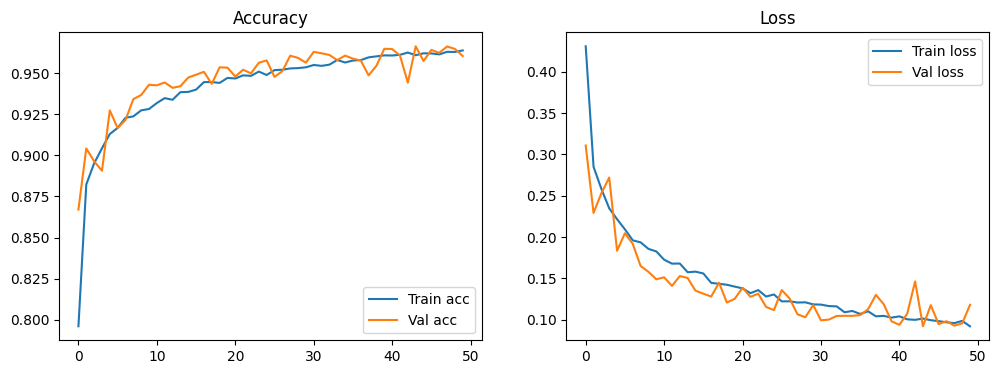

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train acc')
plt.plot(history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
y_pred_probs_bm = best_model.predict(x_test_norm_cnn)
y_pred_bm = (y_pred_probs_bm > 0.5).astype(int).flatten()
y_true = y_test_bin

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_bm, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:

              precision    recall  f1-score   support

     vehicle       0.96      0.94      0.95      4000
 non-vehicle       0.96      0.98      0.97      6000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



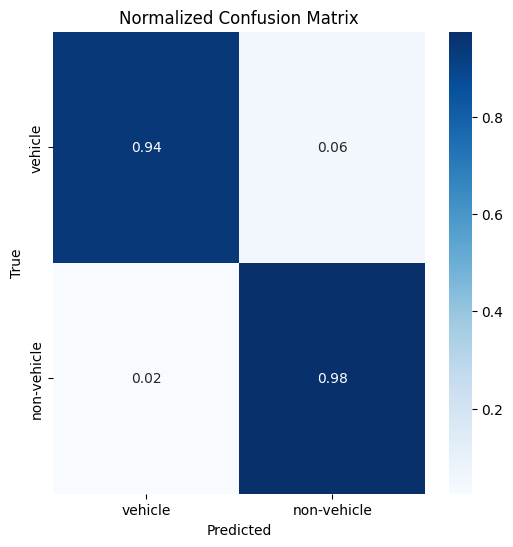

In [ ]:
# Confusion matrix
cm_bm = confusion_matrix(y_true, y_pred_bm, normalize="true")

plt.figure(figsize=(6,6))
sns.heatmap(cm_bm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# General overview of the project and results

## Dataset

For this project, the CIFAR-10 dataset was used. It consists of 60,000 color images of size 32×32 pixels, equally distributed across 10 classes (6,000 images per class). The dataset is split into 50,000 training images and 10,000 test images.

Since the required task was binary classification (vehicle vs. animal), the dataset was remapped accordingly. All vehicle-related categories were grouped under the label vehicle, while the remaining categories were grouped under animal.

The original CIFAR-10 dataset does not provide a dedicated validation set. Therefore, a custom split was created from the training set, dividing it into 70% training and 30% validation.

To increase robustness and prevent overfitting, data augmentation was applied using the ImageDataGenerator utility. Images were normalized to the [0,1] range and augmented with real-time transformations such as rotation, shifting, flipping, zooming, and shearing. On the validation and test sets, only normalization was applied, in order to maintain evaluation integrity.

## Methodology

The chosen model was a custom Convolutional Neural Network (CNN). Initial experimentation with pre-trained architectures (ResNet50) showed poor results, primarily due to the limited size and low resolution of CIFAR-10 images, which did not allow the deeper architectures to leverage their full representational capacity. This mismatch led to overfitting, as the model quickly adapted to the training set without generalizing effectively.

The custom CNN offered a better trade-off between model complexity and generalization ability, making it more suitable for this task.

## CNN Architecture

The final architecture consists of three convolutional blocks with increasing depth (32, 64, 128 filters). Each block includes:

Two convolutional layers with ReLU activation and same padding.

A MaxPooling layer to reduce spatial dimensions.

Dropout (0.25) to mitigate overfitting.

After flattening, the features are passed to a fully connected dense layer with 256 neurons and ReLU activation, followed by an additional Dropout (0.3). The output layer is a single neuron with a sigmoid activation function, providing a binary classification output.

This structure ensures a balance between expressiveness (via deeper convolutional filters) and regularization (via dropout), while keeping the architecture lightweight enough to train efficiently on CIFAR-10.

## Training Setup

Two optimizers were tested:

Adam with an initial learning rate of 1e-3, often considered a strong baseline for image classification.

RMSprop with Cosine Decay, chosen because it has been reported to stabilize training and improve convergence in similar tasks.

The metrics monitored during training were:
* Accuracy (overall classification correctness),
* Precision (quality of positive predictions)
* Recall (sensitivity to positive instances).

A batch size of 256 was selected, as smaller batches yielded unstable learning behavior, likely due to insufficient sample diversity within each batch.

## Experimental Setup

To evaluate the model under different architectural and optimization conditions, three experimental runs were performed:

* Run A (Baseline): Intermediate architecture (32 → 64 → 128, dense=256) trained with Adam (lr=1e-3).

  Purpose: establish a standard reference performance.

* Run B (Stable): Same convolutional backbone as Run A, but trained with RMSprop + Cosine Decay.

  Purpose: evaluate the effect of using a different optimizer and learning rate schedule on convergence stability and validation robustness.

* Run C (Light): Lightweight architecture (16 → 32 → 64, dense=128) trained with Adam.

  Purpose: investigate the trade-off between predictive accuracy and computational efficiency with a reduced-capacity network.

# Results
**Run A (Baseline CNN: 32 → 64 → 128, Dense=256, Adam 1e-3)**

**Comments on curves:**

Both accuracy and loss curves indicate stable convergence, with validation accuracy closely tracking training accuracy and no signs of overfitting. Performance plateaued around 96%.

* Test performance: Accuracy = 96.2%.
* Precision: 0.962 (vehicle), 0.962 (non-vehicle)
* Recall: 0.942 (vehicle), 0.975 (non-vehicle)
* F1-score: 0.952 (vehicle), 0.969 (non-vehicle)

**Confusion matrix:**

Most misclassifications correspond to vehicles predicted as non-vehicles (about 6% of all vehicles), while non-vehicles misclassified as vehicles were less frequent (around 2%).

These results establish Run A as a solid reference model, achieving high accuracy and balanced precision–recall across classes.

# Comparative analysis of Run B and Run C

* **Run B** (RMSprop + CosineDecay, same backbone as Run A) achieved 95.8% accuracy, with slightly lower precision on the vehicle class but smoother validation dynamics, indicating more stable convergence.

* **Run C** (Light CNN: 16 → 32 → 64, Dense=128) achieved 95.3% accuracy, with performance only marginally worse than Run A despite reduced model capacity, highlighting its efficiency potential for constrained environments.

**Final overview**

All three runs surpassed 95% test accuracy, confirming that a carefully designed CNN is well-suited for binary classification on CIFAR-10.

Among the three runs, Run A delivered the best overall accuracy (96.2%) and proved to be the most reliable architecture. Run B offered comparable accuracy with smoother training dynamics, while Run C demonstrated that a lighter model can still achieve competitive performance, making it suitable for edge deployment. Overall, Run A is the recommended configuration, as it provides the best balance between accuracy and complexity.